In [17]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
import matplotlib.gridspec as gridspec

from lib.controller import Controller
from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.camera_settings import CameraSettings

from lib.automation import FileDetector
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter
from lib.file.pickle import Pickler
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.analysis.trace_sifter import TraceSifter, TraceLearner
from scipy import stats

from lib.analysis.cell_roi import SingleCellFinder 

###########################################
# Make a series of 1-frame measure windows from PhotoZ into a movie
# Asks user to annotate DIC/Fluorescence images for electrode + layer and barrel boundaries
#       Puts this metadata into ROI .dat files
# Uses DIC-to-ZDA frame mapping (rotation and scaling) to annotate the PhotoZ frames
# Uses autoPhotoZ to take frame images for move
#  - 8/24/23: 
#        Support any number of barrels.
#        add ROI generation: layer/barrel ROIs
###########################################

In [14]:
# Example 01_02_02.zda on 11/20/23
snr_file = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/01_02_02_snr.dat'
snr_df = pd.read_csv(snr_file, sep='\t', header=None, names=['Index',  'Values'])
snr_df = np.array(snr_df['Values']).reshape((80, 80))
td_tomato_file_dir = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/dic/1-2r.tif'
img = io.imread(td_tomato_file_dir)
img = np.average(img, axis=2)

td_tomato_file_dir2 = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/dic/1-2rr.tif'
img2 = io.imread(td_tomato_file_dir2)
img2 = np.average(img2, axis=2)

'''# Example 01_01_04.zda on 11/20/23
snr_file = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/01_01_04_snr.dat'
snr_df = pd.read_csv(snr_file, sep='\t', header=None, names=['Index',  'Values'])
snr_df = np.array(snr_df['Values']).reshape((80, 80))
snr_df[snr_df < 0] = 0 

td_tomato_file_dir = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/dic/1-1r.tif'
img = io.imread(td_tomato_file_dir)
img = np.average(img, axis=2)

td_tomato_file_dir2 = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/dic/1-1r.tif'
img2 = io.imread(td_tomato_file_dir2)
img2 = np.average(img2, axis=2)'''

"# Example 01_01_04.zda on 11/20/23\nsnr_file = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/01_01_04_snr.dat'\nsnr_df = pd.read_csv(snr_file, sep='\t', header=None, names=['Index',  'Values'])\nsnr_df = np.array(snr_df['Values']).reshape((80, 80))\nsnr_df[snr_df < 0] = 0 \n\ntd_tomato_file_dir = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/dic/1-1r.tif'\nimg = io.imread(td_tomato_file_dir)\nimg = np.average(img, axis=2)\n\ntd_tomato_file_dir2 = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/11-20-23/dic/1-1r.tif'\nimg2 = io.imread(td_tomato_file_dir2)\nimg2 = np.average(img2, axis=2)"

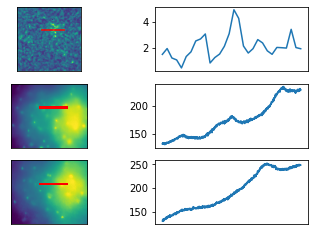

In [15]:
cross_row = np.argmax(snr_df) // 80  # use row that achieves max SNR
#cross_row += 34
x_limits = [30, 60]
scf = SingleCellFinder(snr_df, [img, img2])
cross_sections = scf.take_cross_section_of_arrays(cross_row, x_limits=x_limits)

gs = gridspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0])
ax0.imshow(snr_df)
ax0.hlines(cross_row, x_limits[0], x_limits[1], colors='red')

ax1 = plt.subplot(gs[1])
ax1.plot(cross_sections['snr'])

ax2 = plt.subplot(gs[2])
ax2.imshow(img)

ax3 = plt.subplot(gs[3])
ax3.plot(cross_sections['td_tomato'][0])

ax4 = plt.subplot(gs[4])
ax4.imshow(img2)
td_ln = cross_sections['td_tomato_lines']
for i in range(td_ln[0], td_ln[1]+1):
    for ax in [ax2, ax4]:
        ax.hlines(i, 
                   cross_sections['td_tomato_x_limits'][0], 
                   cross_sections['td_tomato_x_limits'][1], 
                   colors='red')
    
ax5 = plt.subplot(gs[5])
ax5.plot(cross_sections['td_tomato'][1])

for ax in [ax0, ax2, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
for ax in [ax1, ax3, ax5]:
    ax.set_xticks([])

In [ ]:
# align RLI and DIC and record the RLI's image boundaries within the DIC image.
img_aligner = ImageAlign()
if enable_alignment:

    for slic in single_images:
        for loc in single_images[slic]:

            # DICs
            fluor = single_images[slic][loc]['f']
            # img = single_images[slic][loc]['i']
            dic_electrode = single_images[slic][loc]['e']
            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
            
            if len(single_images[slic][loc]['SNR'].keys()) > 0:
                # ask user to trace out shape of electrode (and/or other features)
                dic_electrode = np.array(img_aligner.draw_on_image(dic_electrode))
                plt.imshow(dic_electrode, cmap='gray')
                plt.show()
                first_alignment = None
            
            for rec in single_images[slic][loc]['SNR']:

                if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                    
                    print("\n\n\n *********** Slice", str(slic) + ", Loc", str(loc) + ", Rec", str(rec), "*********** ")
                    
                    if align_only_first_rec and first_alignment is not None:
                        single_images[slic][loc]['RLI'][rec]['alignment'] = first_alignment
                        continue

                    rli = single_images[slic][loc]['RLI'][rec]['data']
                    rli = np.array(rli * 255, dtype=np.uint8)
                    rli = np.array(img_aligner.draw_on_image(rli))
                    plt.imshow(rli, cmap='gray')
                    plt.show()
                    
                    alignment_corners = []
                    
                    # user drags image to align
                    nw_drag_corner = img_aligner.drag_to_align(dic_electrode, rli)
                    print(nw_drag_corner)
                    
                    # store alignment info
                    single_images[slic][loc]['RLI'][rec]['alignment'] = alignment_corners
                    if align_only_first_rec:
                        first_alignment = single_images[slic][loc]['RLI'][rec]['alignment']


In [ ]:
roi = GMM_ROI_Identifier()
reg_exp = RegionExporter()

In [ ]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [ [98, 100]]
if quick_test:
    percentile_strata = [ [95, 100]]

for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = k_cluster

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=num_regions_to_export)
                        
                        print("***********************\n\n\n\n\n")
                        
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata

In [ ]:
for slic in single_images:
    for loc in single_images[slic]:
        print(slic, loc)
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                
                # Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
                if 'pixel_roi_occurrence_map' not in single_images[slic][loc]:
                    single_images[slic][loc]['pixel_roi_occurrence_map'] = np.zeros(snr.shape)
                    
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                # FYI, a stratum is just a list of Cluster objs (see ROI_Identification.py)
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                # Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
                for stratum in cluster_strata:
                    for cluster in stratum:
                        for px in cluster.get_pixels():
                            y, x = px
                            single_images[slic][loc]['pixel_roi_occurrence_map'][x, y] += 1


In [ ]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        rli_image = None
                        try:
                            single_images[slic][loc]['RLI'][rec]['data']
                        except Exception as e:
                            print("No RLI image to lay over")
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, 
                                                show=False, 
                                                plot_sample_heatmap=False,
                                                overlay_image=rli_image)
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # export only the highest SNR clusters.
                        regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                            limit=num_regions_to_export,
                                                            snr=snr)

                        # Export ROIs to ImageZ format for region drawing
                        all_px_regions = roi_write.get_regions_by_pixel()
                        filename = dat_dir + "ImageZ" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        filename = filename[:-4] + ".tsv"
                        reg_exp.export(filename, all_px_regions)
                        
                        single_images[slic][loc]['SNR'][rec]['final_ROIs'] = all_px_regions
                        single_images[slic][loc]['SNR'][rec]['final_ROIs_filename'] = filename
                    
                plt.show()

In [6]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
google_drive_dir = "G:/.shortcut-targets-by-id/1afwzLrN3AQQPbJ1PQiZlKAb1Bijc5qln/Choosing trajectories/"
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
start_frame = 94
movie_length = 27
camera_program = 4
which_rig = 'new'  # change to 'old' for old rig dic alignment
date_format = 'yy-mm-dd'
if which_rig == 'old':
    date_format = 'yyyy-mm-dd'

# annotation settings
skip_draw_annotations = False  # If True, don't draw any new annotations

# Movie maker settings
disable_photoZ_interact = False
initialize_photoZ = True
clean_scratch_files = False  # clean up SNR maps
replace_existing_frame_pngs = False
disable_google_drive_interact = True
image_border_width = 8
image_scaling = 7  # pixels of image per array diode pixel
electrode_marker_radius = 4

In [7]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and not disable_photoZ_interact:
    aPhz.prepare_photoZ()
if not disable_photoZ_interact:
    aPhz.click_normalize_2_array_max()
    pa.alert("Please disable trace overlay and maximize PhotoZ before continuing.")

pa.click(x, y)


In [4]:
# run this cell to refresh and re-do all processing.
rec_id_skip_list = []


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-17-23

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
3 2
Number of shapes drawn: 1
Number of shapes drawn: 4


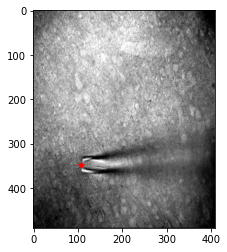

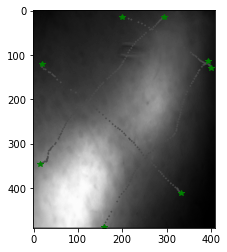


 	coords_electrode {'electrode': [107.85714285714286, 347.35714285714283]}
	coords_layers {'layer_axis1': [[293, 14], [15, 346]], 'layer_axis2': [[394, 114], [158, 488]], 'barrel_axis1': [[18, 121], [332, 411]], 'barrel_axis2': [[199, 15], [401, 130]]}
Electrode point: [23, 52]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_02_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_02_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_02_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_02_01/


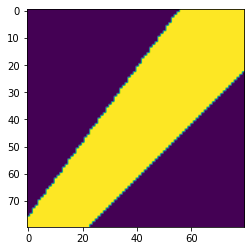

2601 2601
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


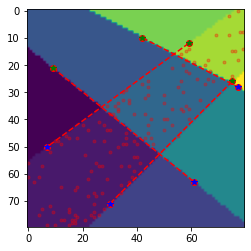

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice3_2_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice3_2_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
3 3
Number of shapes drawn: 1
Number of shapes drawn: 4


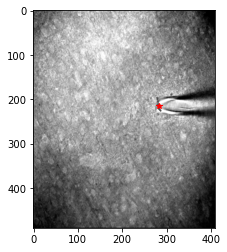

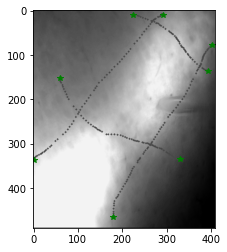


 	coords_electrode {'electrode': [282.6842105263158, 214.78947368421052]}
	coords_layers {'layer_axis1': [[291, 9], [0, 337]], 'layer_axis2': [[402, 77], [179, 466]], 'barrel_axis1': [[60, 153], [329, 335]], 'barrel_axis2': [[224, 10], [393, 137]]}
Electrode point: [55, 37]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_03_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_03_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_03_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis03_03_01/


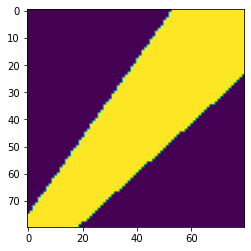

2660 2660
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


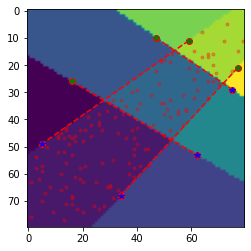

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice3_3_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice3_3_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 1
Number of shapes drawn: 1
Number of shapes drawn: 4


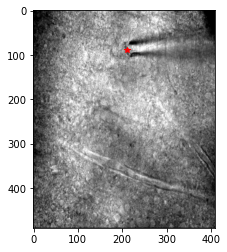

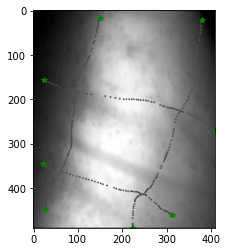


 	coords_electrode {'electrode': [210.47619047619048, 88.85714285714286]}
	coords_layers {'layer_axis1': [[149, 17], [26, 447]], 'layer_axis2': [[379, 22], [224, 489]], 'barrel_axis1': [[24, 157], [409, 271]], 'barrel_axis2': [[22, 346], [313, 461]]}
Electrode point: [44, 20]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_01_03/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_01_03/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_01_03/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_01_03/


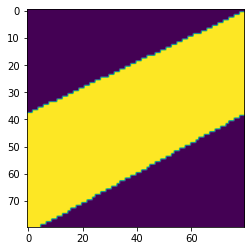

3263 3263
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


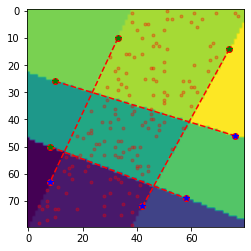

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_1_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_1_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 2
Number of shapes drawn: 1
Number of shapes drawn: 4


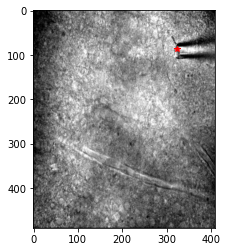

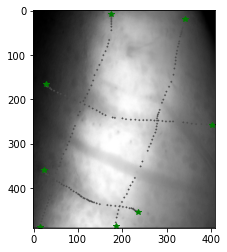


 	coords_electrode {'electrode': [323.95238095238096, 86.0952380952381]}
	coords_layers {'layer_axis1': [[175, 7], [15, 488]], 'layer_axis2': [[342, 18], [185, 485]], 'barrel_axis1': [[27, 166], [403, 258]], 'barrel_axis2': [[23, 359], [236, 454]]}
Electrode point: [63, 21]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_02_03/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_02_03/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_02_03/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_02_03/


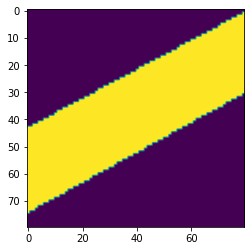

2451 2451
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


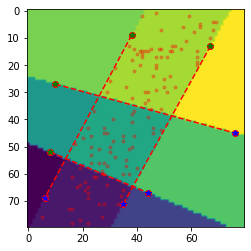

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_2_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_2_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 3
Number of shapes drawn: 1
Number of shapes drawn: 4


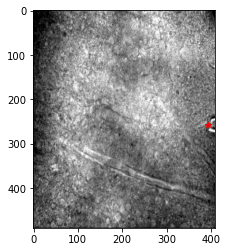

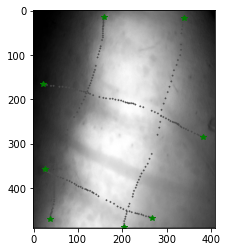


 	coords_electrode {'electrode': [393.8, 257.5]}
	coords_layers {'layer_axis1': [[159, 15], [36, 470]], 'layer_axis2': [[338, 17], [204, 488]], 'barrel_axis1': [[21, 166], [381, 284]], 'barrel_axis2': [[25, 358], [268, 467]]}
Electrode point: [74, 44]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_03_03/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_03_03/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_03_03/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_03_03/


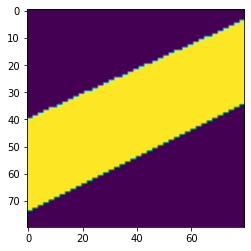

2596 2596
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


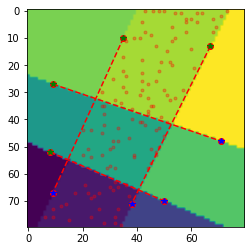

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_3_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_3_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 4
Number of shapes drawn: 1
Number of shapes drawn: 4


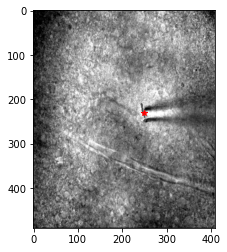

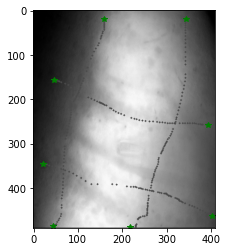


 	coords_electrode {'electrode': [247.94444444444446, 230.5]}
	coords_layers {'layer_axis1': [[159, 19], [43, 485]], 'layer_axis2': [[343, 20], [217, 487]], 'barrel_axis1': [[47, 156], [394, 257]], 'barrel_axis2': [[22, 345], [402, 464]]}
Electrode point: [49, 39]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_04_03/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_04_03/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_04_03/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_04_03/


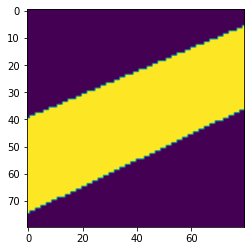

2617 2617
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


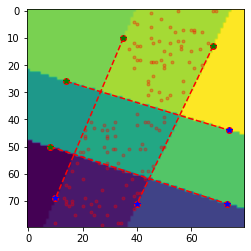

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_4_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_4_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 5
Number of shapes drawn: 1
Number of shapes drawn: 4


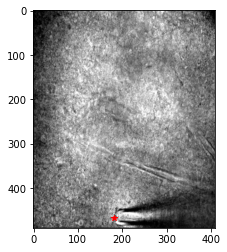

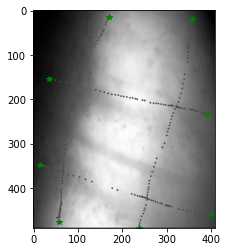


 	coords_electrode {'electrode': [182.0, 467.46153846153845]}
	coords_layers {'layer_axis1': [[170, 15], [57, 477]], 'layer_axis2': [[357, 20], [237, 489]], 'barrel_axis1': [[34, 154], [390, 233]], 'barrel_axis2': [[14, 349], [400, 459]]}
Electrode point: [34, 68]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_05_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_05_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_05_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_05_02/


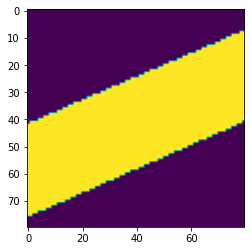

2722 2722
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


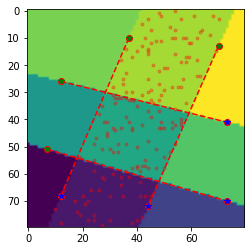

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_5_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_5_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 6
Number of shapes drawn: 1
Number of shapes drawn: 4


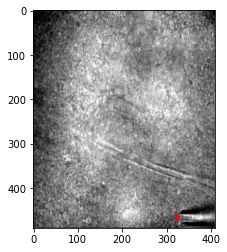

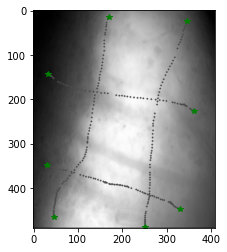


 	coords_electrode {'electrode': [324.0, 464.6875]}
	coords_layers {'layer_axis1': [[170, 15], [46, 465]], 'layer_axis2': [[346, 24], [251, 488]], 'barrel_axis1': [[33, 142], [361, 226]], 'barrel_axis2': [[30, 347], [331, 447]]}
Electrode point: [59, 70]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_06_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_06_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_06_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_06_02/


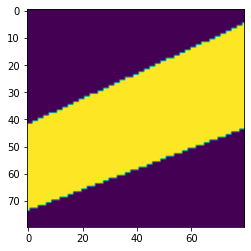

2803 2803
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


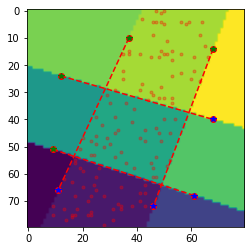

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_6_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_6_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
4 7
Number of shapes drawn: 1
Number of shapes drawn: 4


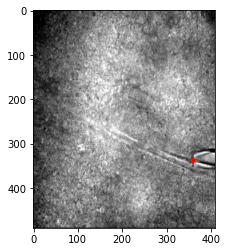

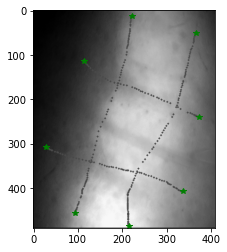


 	coords_electrode {'electrode': [360.05882352941177, 336.2352941176471]}
	coords_layers {'layer_axis1': [[221, 12], [94, 456]], 'layer_axis2': [[365, 50], [214, 485]], 'barrel_axis1': [[113, 113], [373, 240]], 'barrel_axis2': [[27, 307], [336, 407]]}
Electrode point: [67, 54]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_07_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_07_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_07_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis04_07_02/


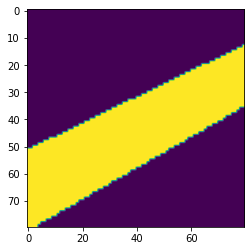

2103 2103
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


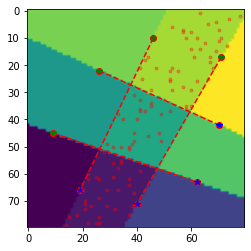

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice4_7_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice4_7_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
5 1
Number of shapes drawn: 1
Number of shapes drawn: 4


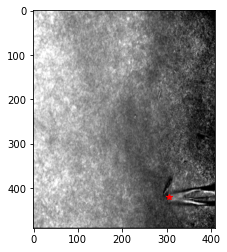

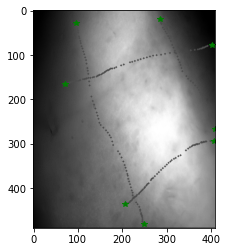


 	coords_electrode {'electrode': [306.2142857142857, 420.07142857142856]}
	coords_layers {'layer_axis1': [[96, 29], [248, 481]], 'layer_axis2': [[286, 19], [409, 266]], 'barrel_axis1': [[72, 165], [403, 77]], 'barrel_axis2': [[206, 436], [406, 293]]}
Electrode point: [57, 64]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_01_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_01_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_01_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_01_02/


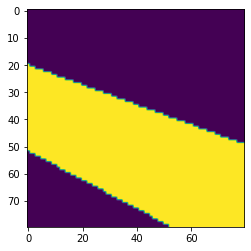

2858 2858
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


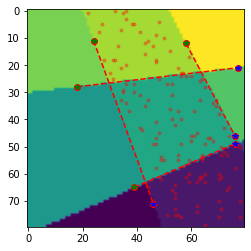

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice5_1_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice5_1_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
5 2
Number of shapes drawn: 1
Number of shapes drawn: 4


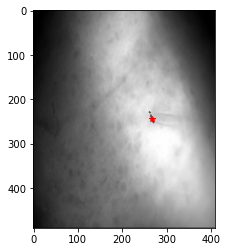

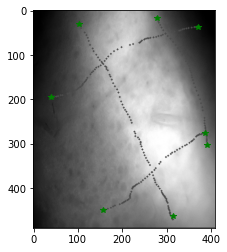


 	coords_electrode {'electrode': [267.64285714285717, 243.35714285714286]}
	coords_layers {'layer_axis1': [[103, 30], [315, 464]], 'layer_axis2': [[278, 17], [392, 303]], 'barrel_axis1': [[39, 195], [371, 37]], 'barrel_axis2': [[157, 450], [387, 275]]}
Electrode point: [52, 41]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_02_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_02_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_02_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_02_02/


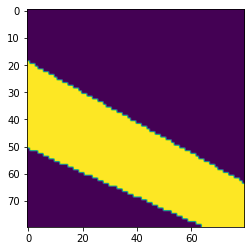

2139 2139
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


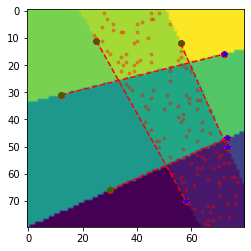

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice5_2_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice5_2_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
5 3
Number of shapes drawn: 1
Number of shapes drawn: 4


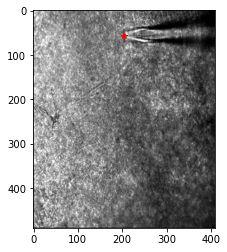

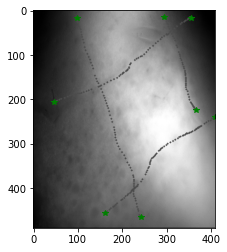


 	coords_electrode {'electrode': [204.375, 57.5625]}
	coords_layers {'layer_axis1': [[98, 16], [242, 466]], 'layer_axis2': [[294, 15], [366, 224]], 'barrel_axis1': [[47, 205], [355, 16]], 'barrel_axis2': [[161, 457], [408, 240]]}
Electrode point: [43, 16]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_03_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_03_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_03_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_03_01/


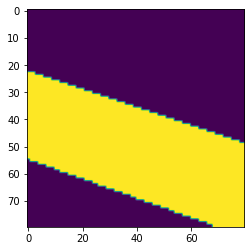

2663 2663
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


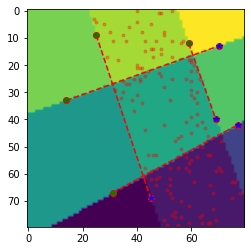

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice5_3_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice5_3_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
5 4
Number of shapes drawn: 1
Number of shapes drawn: 4


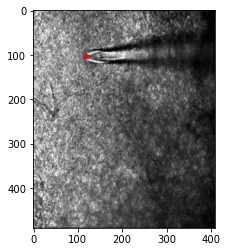

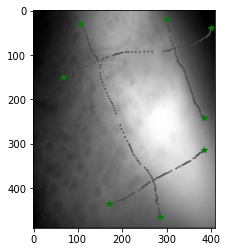


 	coords_electrode {'electrode': [118.61538461538461, 101.61538461538461]}
	coords_layers {'layer_axis1': [[104, 30], [285, 465]], 'layer_axis2': [[298, 18], [384, 243]], 'barrel_axis1': [[66, 150], [400, 40]], 'barrel_axis2': [[170, 436], [384, 314]]}
Electrode point: [27, 20]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_04_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_04_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_04_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_04_01/


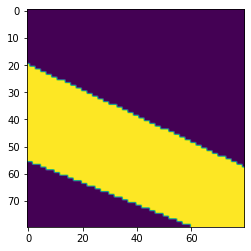

2533 2533
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


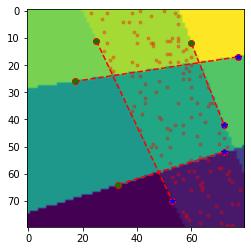

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice5_4_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice5_4_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
5 5
Number of shapes drawn: 1
Number of shapes drawn: 4


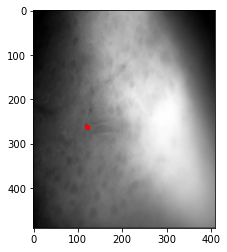

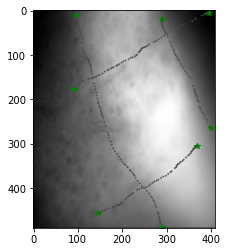


 	coords_electrode {'electrode': [121.5, 262.375]}
	coords_layers {'layer_axis1': [[95, 11], [290, 488]], 'layer_axis2': [[290, 19], [400, 265]], 'barrel_axis1': [[92, 176], [395, 5]], 'barrel_axis2': [[146, 456], [369, 305]]}
Electrode point: [26, 41]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_05_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_05_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_05_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_05_01/


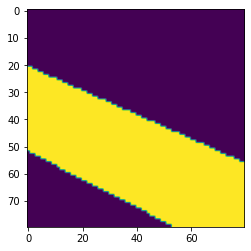

2558 2558
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


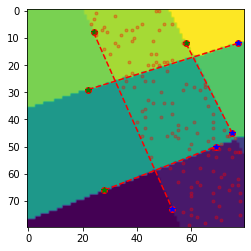

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice5_5_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice5_5_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
5 6
Number of shapes drawn: 1
Number of shapes drawn: 4


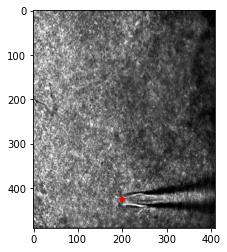

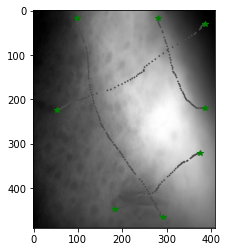


 	coords_electrode {'electrode': [199.58823529411765, 425.47058823529414]}
	coords_layers {'layer_axis1': [[97, 17], [291, 465]], 'layer_axis2': [[280, 16], [387, 220]], 'barrel_axis1': [[52, 224], [387, 30]], 'barrel_axis2': [[183, 447], [375, 320]]}
Electrode point: [38, 63]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_06_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_06_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_06_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis05_06_02/


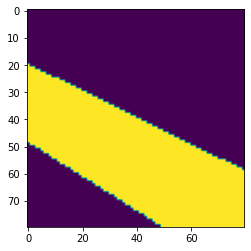

2459 2459
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


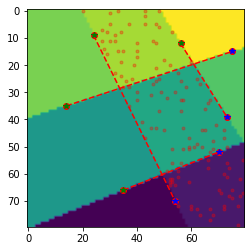

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice5_6_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice5_6_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
6 1
Number of shapes drawn: 1
Number of shapes drawn: 4


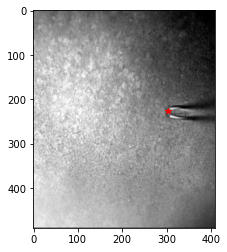

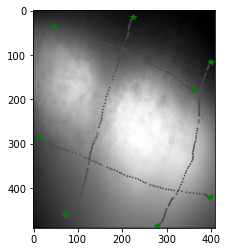


 	coords_electrode {'electrode': [302.90909090909093, 226.86363636363637]}
	coords_layers {'layer_axis1': [[46, 35], [362, 180]], 'layer_axis2': [[13, 284], [397, 421]], 'barrel_axis1': [[224, 14], [70, 456]], 'barrel_axis2': [[399, 115], [279, 486]]}
Electrode point: [58, 39]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_01_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_01_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_01_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_01_01/


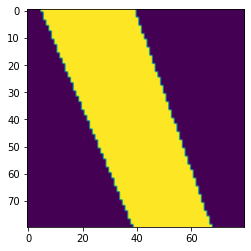

2537 2537
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


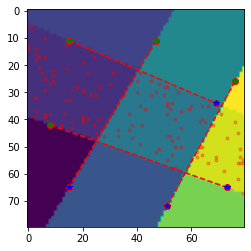

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice6_1_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice6_1_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
6 2
Number of shapes drawn: 1
Number of shapes drawn: 4


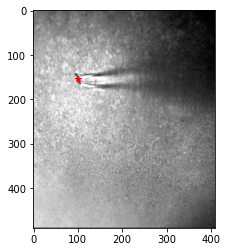

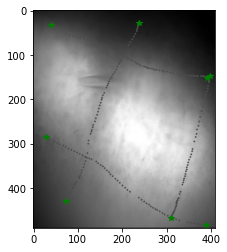


 	coords_electrode {'electrode': [101.16666666666667, 154.72222222222223]}
	coords_layers {'layer_axis1': [[39, 32], [392, 151]], 'layer_axis2': [[27, 284], [389, 484]], 'barrel_axis1': [[237, 29], [73, 429]], 'barrel_axis2': [[398, 147], [309, 468]]}
Electrode point: [24, 27]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_02_02/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_02_02/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_02_02/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_02_02/


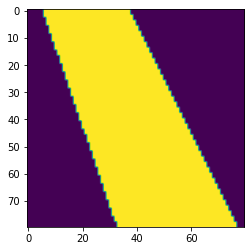

3059 3059
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


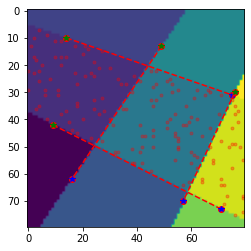

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice6_2_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice6_2_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
6 3
Number of shapes drawn: 1
Number of shapes drawn: 4


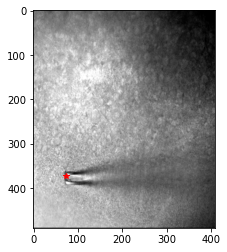

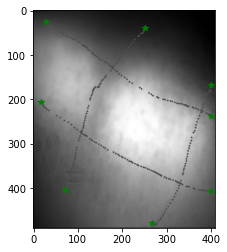


 	coords_electrode {'electrode': [73.0, 373.8333333333333]}
	coords_layers {'layer_axis1': [[27, 26], [401, 237]], 'layer_axis2': [[17, 207], [401, 407]], 'barrel_axis1': [[252, 40], [71, 405]], 'barrel_axis2': [[400, 168], [267, 479]]}
Electrode point: [16, 55]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_03_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_03_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_03_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_03_01/


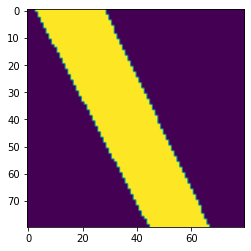

1911 1911
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


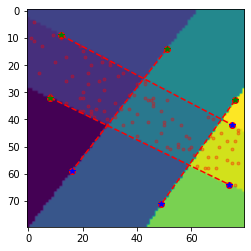

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice6_3_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice6_3_rois.dat

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23
6 4
Number of shapes drawn: 1
Number of shapes drawn: 4


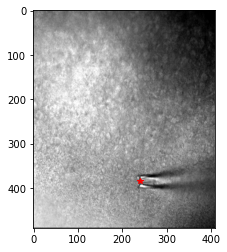

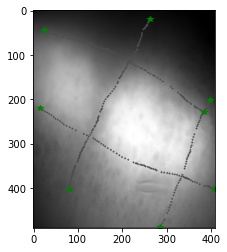


 	coords_electrode {'electrode': [239.38888888888889, 385.0]}
	coords_layers {'layer_axis1': [[23, 43], [384, 229]], 'layer_axis2': [[14, 219], [406, 401]], 'barrel_axis1': [[262, 19], [80, 402]], 'barrel_axis2': [[397, 202], [286, 487]]}
Electrode point: [45, 59]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_04_01/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_04_01/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_04_01/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda//analysis06_04_01/


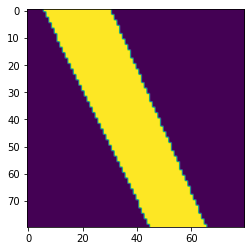

1825 1825
PX_MAP should be divided into 3 layers at this point. Number of unique layers found: 3


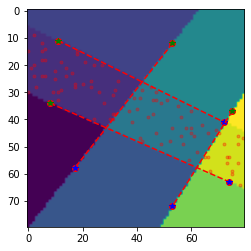

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layers_barrels_slice6_4_rois.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/10-19-23/selected_zda/layer4_barrels_slice6_4_rois.dat


In [5]:
# First ask user to annotate some images with Electrode loc and L4 boundaries and layer text placement
# based on DIC-to-ZDA_Alignment script
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        already_drawn_slic_loc = {}
        
        # optionally process date
        date = ""
        try:
            char_select = -len(date_format)
            date = subdir.split("_Usable")[0][char_select:]
            date = [int(x) for x in date.split("-")]
            if date_format != 'yyyy-mm-dd':
                date[2] += 2000  # full year format
            else:
                date = [date[1], date[2], date[0]]
            date = "/".join([str(d) for d in date])
        except Exception as e:
            print(e, "could not process date.")

        # take selected zda and expand into separate subdir for each zda file
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                if subdir+rec_id in rec_id_skip_list:
                    continue
                print("\n", subdir)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                # output dir
                output_dir = selected_zda_dir + "/analysis" + rec_id + "/"
                try:
                    os.makedirs(output_dir)
                except Exception as e:
                    pass

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id)

                # align RLI and DIC and record the RLI's image boundaries within the DIC image.
                img_aligner = ImageAlign(rig=which_rig)

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)

                        # if already drawn, no need to ask user again
                        if str(slic_id)+"_"+str(loc_id) in already_drawn_slic_loc:
                            # just copy them over
                            src_dir = already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)]
                            electrode_file = src_dir + "electrode.dat"
                            corners_layer_file = src_dir + "corners_layer.dat"
                            corners_barrel_file = src_dir + "corners_barrel.dat"
                            shutil.copy(electrode_file, output_dir + "electrode.dat")
                            shutil.copy(corners_layer_file, output_dir + "corners_layer.dat")
                            shutil.copy(corners_barrel_file, output_dir + "corners_barrel.dat")
                            print("Copied previous annotations over.")
                            continue

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor
                            
                        if which_rig != 'new':
                            fluor = dic_electrode

                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)
                        orig_arr_shape = dic_electrode.shape

                        # ask user to select site of stim and layer/barrel borders
                        electrode_file = output_dir + "electrode.dat"
                        corners_layer_file = output_dir + "corners_layer.dat"
                        corners_barrel_file = output_dir + "corners_barrel.dat"
                        if not skip_draw_annotations:
                            dic_electrode, coords_electrode, dic_layers, coords_layers = \
                                img_aligner.draw_on_images_wrapper(
                                    dic_electrode, 
                                    fluor, 
                                    date + " " + rec_id + " ")
                            dic_electrode = np.array(dic_electrode)
                            dic_layers = np.array(dic_layers)
                            
                            plt.imshow(dic_electrode, cmap='gray')
                            x_el, y_el = coords_electrode['electrode']
                            plt.plot(x_el, y_el, marker="*", color='red')
                            dcs = []
                            if which_rig != 'new':  # show the portion of frame which is PhotoZ
                                photoZ_frame_coords = img_aligner.dic_coordinates
                                for dc_c in photoZ_frame_coords:
                                    x_c = dc_c[0] * dic_electrode.shape[1]
                                    y_c = dc_c[1] * dic_electrode.shape[0]
                                    dcs.append([x_c, y_c])
                                print(dcs)
                                for ic, jc in [[0,1],[1,3],[3,2],[2,0]]:
                                    plt.plot([dcs[ic][0], dcs[jc][0]], [dcs[ic][1], dcs[jc][1]], 
                                             color="white", 
                                             linewidth=3)
                            plt.show()

                            plt.imshow(dic_layers, cmap='gray')
                            for key_pt in coords_layers:
                                if "_axis" in key_pt:
                                    for pt in coords_layers[key_pt]:
                                        x, y = pt
                                        plt.plot(x, y, marker="*", color='green')
                            if which_rig != 'new':  # show the portion of frame which is PhotoZ
                                photoZ_frame_coords = img_aligner.dic_coordinates
                                for ic, jc in [[0,1],[1,3],[3,2],[2,0]]:
                                    plt.plot([dcs[ic][0], dcs[jc][0]], [dcs[ic][1], dcs[jc][1]], 
                                             color="white", 
                                             linewidth=3)
                            plt.show()

                            try:
                                os.makedirs(output_dir)
                            except OSError:
                                pass

                            # transform coordinates -- Actual alignment work done here
                            print("\n \tcoords_electrode", coords_electrode)
                            print("\tcoords_layers", coords_layers)
                            coords_electrode = img_aligner.transform_from_dic_coordinates(coords_electrode, orig_arr_shape)
                            coords_layers = img_aligner.transform_from_dic_coordinates(coords_layers, orig_arr_shape)
                            coordinates = coords_electrode | coords_layers

                            # write electrode and corners to file
                            img_aligner.write_shapes_to_files(coordinates,
                                                              electrode_file,
                                                              corners_layer_file,
                                                              corners_barrel_file,
                                                              preserve_initial_order=True)
                            print("Wrote files to", output_dir)

                        ############################################
                        # Create ROIs for each layer/barrel division
                        ############################################
                        # read barrel and layer axes data back in
                        # create collections of pixels by LAYER so we can create separate files for each LAYER'S barrels
                        barrel_layer_axes = []  # going to be a list of Line objects, first 2 are layer boundaries, rest are barrel boundaries
                        for la_file in [corners_layer_file, corners_barrel_file]:
                            with open(la_file, 'r') as f:
                                lines = f.readlines() 
                            roi_px_ct = int(lines[2]) - 1 
                            corners = [int(x) for x in lines[4:]] # the last lines are diode numbers of corners
                            if len(corners) != roi_px_ct:
                                raise Exception("Likely an error processing corners. Expected " + 
                                                str(roi_px_ct) + " pixels.")
                            layer_axes = LayerAxes(corners[:4], verbose=False, obey_initial_order=True)
                            laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                            barrel_layer_axes.append(laminar_axis)
                            barrel_layer_axes.append(laminar_axis_2)

                            rest_of_corners = LaminarROI(corners[4:]).get_points()
                            for j in range(0, len(rest_of_corners), 2):
                                if len(rest_of_corners) > j+1:
                                    barrel_layer_axes.append(Line(rest_of_corners[j], rest_of_corners[j+1]))

                        # Now we will divide into L2/3, L4, L5 and barrels
                        w, h = LaminarROI([]).get_dimensions()
                        
                        # first two are guaranteed to be LAYER divisions
                        layer_4_list = {}
                        layer_axis_1 = barrel_layer_axes[0]
                        layer_axis_2 = barrel_layer_axes[1]
                        px_map_1 = layer_axis_1.get_split_px_map() 
                        px_map_2 = layer_axis_2.get_split_px_map()
                        px_map = px_map_1 + px_map_2 * 2
                        layer_4_px_map = np.logical_xor(px_map_1, px_map_2)
                        
                        # find the number of connected domains in layer_4_px_map
                        if not Line.has_one_connected_domain(layer_4_px_map):
                            print("Flipping L4 map!")
                            layer_4_px_map = np.ones(layer_4_px_map.shape) - layer_4_px_map
                        
                        # convert layer 4 px map to list format
                        for i in range(w):
                            for j in range(h):
                                if layer_4_px_map[i,j] > 0:
                                    layer_4_list[str(i) + "_" + str(j)] = [i, j]

                        n_unique_rois = np.unique(px_map)  # should match the number of ROIs expected, which is 3 so far
                        print("PX_MAP should be divided into 3 layers at this point. " +
                                            "Number of unique layers found: " + str(len(n_unique_rois)) )
                        
                        # Now divide into ROIs
                        incrementer = 4
                        for axis in barrel_layer_axes[2:]: # rest of these are barrel divisions
                            for i in range(w):
                                for j in range(h):
                                    if axis.is_point_left_of_line([i, j]):
                                        px_map[i, j] += incrementer
                            incrementer *= 2
                            
                        n_unique_rois = np.unique(px_map)  # should match the number of ROIs expected
                        roi_id_map = {}
                        roi_layer_4_map = {}
                        layer4_idxs = {}
                        for i in range(len(n_unique_rois)):
                            roi_id_map[n_unique_rois[i]] = i

                        plt.clf()
                        plt.imshow(np.transpose(px_map))
                        for axis in barrel_layer_axes:
                            p1, p2 = axis.get_line_repr()
                            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro', linestyle="--")
                            plt.plot(p1[0], p1[1], marker="*", color='green')
                            plt.plot(p2[0], p2[1], marker="*", color='blue')
                        for k in layer_4_list:
                            if random.random() > 0.95:
                                l4_pt = layer_4_list[k]
                                plt.plot(l4_pt[0], l4_pt[1], marker=".", color='red', alpha=0.3)
                        plt.show()

                        # Then we will take this Pixel classification map and turn into ROIs
                        roi_list = [[] for _ in range(len(n_unique_rois))]  # doubly-nested list of regions
                        roi_writer = ROIFileWriter()
                        roi_creater = ROICreator(None)
                        roi_output_file = selected_zda_dir + "layers_barrels_slice" + str(slic) + "_" + str(loc) +"_rois.dat"
                        for i in range(w):
                            for j in range(h):
                                roi_idx = roi_id_map[px_map[i, j]]
                                dn = roi_creater.convert_point_to_diode_number([i, j])
                                roi_list[roi_idx].append(dn)
                        roi_writer.write_regions_to_dat(roi_output_file, roi_list)
                        
                        # now write a separate file with only layer 4 rois
                        l4_roi_list = [[] for _ in range(len(n_unique_rois))]
                        l4_roi_output_file = selected_zda_dir + "layer4_barrels_slice" + str(slic)  + "_" + str(loc) +"_rois.dat"
                        for i in range(w):
                            for j in range(h):
                                if str(i) + "_" + str(j) in layer_4_list:
                                    roi_idx = roi_id_map[px_map[i, j]]
                                    dn = roi_creater.convert_point_to_diode_number([i, j])
                                    l4_roi_list[roi_idx].append(dn)
                        # filter empty ROIs
                        l4_roi_list = [r for r in l4_roi_list if len(r) > 0]
                        roi_writer.write_regions_to_dat(l4_roi_output_file, l4_roi_list)

                        # mark this slice/loc already drawn 
                        already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)] = output_dir
                image_data.clear()
                rec_id_skip_list.append(subdir+rec_id)

In [7]:
current_color_bound_setting = 1.0
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'mm_hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print(subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"

        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):

                rec_id = zda_file.split('.')[0]
                print(rec_id)
                # movie dir
                output_dir = selected_zda_dir + "/analysis" + rec_id + "/"
                try:
                    os.makedirs(output_dir)
                except Exception as e:
                    pass

                # determine if we are even missing any jpg'd frames
                need_to_open_zda = True
                for frame in range(start_frame, start_frame + movie_length):
                    filename = output_dir + str(frame) + ".jpg"
                    if not os.path.exists(filename):
                        need_to_open_zda = True
                        break
                if not need_to_open_zda and not replace_existing_frame_pngs:
                    continue

                recording_max_snr = 20.0  # gets changed

                if not disable_photoZ_interact:
                    aPhz = AutoPhotoZ(data_dir=selected_zda_dir)
                    # open the PhotoZ file
                    aPhz.select_PhotoZ()

                    print("\n\nOpening", zda_file)
                    aPhz.open_zda_file(selected_zda_dir + "/" + zda_file)

                    # estimate the SNR max across all frames
                    aPhz.set_measure_window(start_frame, movie_length)
                    filename = aPhz.save_background()
                    print("Saved intermed_snr_df file:", filename)
                    if filename is not None:  # otherwise, sticks with default rec max of 20

                        # open Data.dat and read in the array max
                        intermed_snr_df = pd.read_csv(filename, 
                                                      sep='\t', 
                                                      header=None, 
                                                      names=['Index',  'Values'])
                        recording_max_snr = intermed_snr_df['Values'].max()

                        recording_max_snr *= 1.05  # 5% higher for headroom
                        recording_max_snr = round(recording_max_snr, 2)
                        if clean_scratch_files:
                            try:
                                os.remove(filename)
                            except Exception as e:
                                print("Could not remove", filename)
                                print(e)

                    # set the normalization to be consistent across entire video
                    aPhz.set_color_upper_bound(recording_max_snr, current_color_bound_setting)
                    print("Moved color upper bound from", current_color_bound_setting, "to", recording_max_snr)
                    current_color_bound_setting = recording_max_snr

                    # set measure window width to 1
                    aPhz.set_measure_window(None, 1)

                ##### Get frame annotation: layer and stim markings, and store #####

                # file conventions across
                electrode_file = output_dir + "/electrode.dat"
                corners_layer_file = output_dir + "/corners_layer.dat"
                corners_barrel_file = output_dir + "/corners_barrel.dat"
                annotations_enabled = all([os.path.exists(f) for f in [electrode_file, 
                                                                       corners_layer_file, 
                                                                       corners_barrel_file]])

                def array_point_to_image_pixel(arr_pt):
                    x_arr, y_arr = arr_pt
                    return [image_border_width + image_scaling * x_arr, 
                            image_border_width + image_scaling * y_arr]

                if annotations_enabled:
                    # read in electrode location
                    with open(electrode_file, 'r') as f:
                        lines = f.readlines()
                    stim_pt = int(lines[-1]) # last line is always electrode location
                    aux_obj = LaminarROI([stim_pt]).get_points()
                    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                    print("Stim point:", stim_pt)
                    stim_img_px = array_point_to_image_pixel(stim_pt)
                    stim_xy = (stim_img_px[0] - electrode_marker_radius, 
                               stim_img_px[1] - electrode_marker_radius, 
                               stim_img_px[0] + electrode_marker_radius, 
                               stim_img_px[1] + electrode_marker_radius)
                    # read in corners files
                    la_corners = {corners_layer_file: {},
                                  corners_barrel_file: {}}
                    for la_file in [corners_layer_file, corners_barrel_file]:
                        with open(la_file, 'r') as f:
                            lines = f.readlines() 
                        corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                        layer_axes = LayerAxes(corners, obey_initial_order=True)
                        laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                        print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                              laminar_axis_2.get_unit_vector())

                        end = array_point_to_image_pixel(laminar_axis.get_end_point())
                        end2 = array_point_to_image_pixel(laminar_axis_2.get_end_point())
                        start = array_point_to_image_pixel(laminar_axis.get_start_point())
                        start2 = array_point_to_image_pixel(laminar_axis_2.get_start_point())
                        la_corners[la_file]["line_loc"] = [start + end, start2 + end2]
                        la_corners[la_file]["text_loc"] = (int((end[0] + end2[0]) / 2), 
                                                           int((end[1] + end2[1]) / 2))


                images = []
                img_filenames = []
                for frame in range(start_frame, start_frame + movie_length):
                    filename = output_dir + str(frame) + ".jpg"
                    if replace_existing_frame_pngs or not os.path.exists(filename):
                        # change frame
                        if not disable_photoZ_interact:
                            aPhz.set_measure_window(frame, None)

                            # export this frame
                            aPhz.save_map_jpeg(filename)
                            print("File created:", filename)

                    if annotations_enabled:
                        # draw electrode location on image <filename>
                        image = Image.open(filename)
                        draw = ImageDraw.Draw(image)
                        draw.ellipse(stim_xy, outline='red', width=2)
                        # read in corners files
                        for la_file in [corners_layer_file, corners_barrel_file]:
                            draw.line(la_corners[la_file]["line_loc"][0], fill='white', width=2)
                            draw.line(la_corners[la_file]["line_loc"][1], fill='white', width=2)
                            if la_file == corners_layer_file:
                                draw.text(la_corners[la_file]["text_loc"], "L4", anchor="ms")
                        # PIL image write back
                        image.save(filename)

                    try:
                        images.append(imageio.imread(filename))
                        img_filenames.append(filename)
                    except Exception as e:
                        pass

                # create gif
                created_movie = False
                try:
                    imageio.mimsave(output_dir + rec_id + 'movie.gif', images)
                    print("CREATED MOVIE:", rec_id + 'movie.gif')
                    created_movie = True
                    if clean_scratch_files:
                        for img_file in img_filenames:
                            os.remove(img_file)
                except Exception as e:
                    if not created_movie:
                        print("Not creating movie for " + rec_id)
                    print(e)

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Anna's\2022-09-02_Usable_hidden
02_01_03


Opening 02_01_03.zda


KeyboardInterrupt: 

## 